# Introduction

This Notebook is part of Kaggle Playground competition called What's Cooking. In this Notebook, we will explore the dataset, and try some models prior to submit the dataset to Kaggle.

The objective is to predict the recipe's origin based on ingredients.

# Loading data

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import os

plt.rcParams['figure.figsize'] = (20,12)

In [2]:
import json

with open("../input/train.json") as f:
    train = json.load(f)
    
with open("../input/test.json") as f:
    val = json.load(f)

In [3]:
X_train = []
y_train = []
for recipe in train:
    if len(recipe["ingredients"]) < 2:
        if recipe["ingredients"][0] in ["butter", "water", "sweetened condensed milk", "unsalted butter", "vegetable oil", "cherry tomatoes", "lemonade concentrate", "grained"]:
            print("pass", recipe)
            pass
        else:
            X_train.append(recipe["ingredients"])
            y_train.append(recipe["cuisine"])
    else:
        X_train.append(recipe["ingredients"])
        y_train.append(recipe["cuisine"])

ID_val = []
X_val = []
for recipe in val:
    X_val.append(recipe["ingredients"])
    ID_val.append(recipe["id"])
    
y_train_filtered = np.array(y_train)

pass {'id': 19772, 'cuisine': 'indian', 'ingredients': ['unsalted butter']}
pass {'id': 41124, 'cuisine': 'indian', 'ingredients': ['butter']}
pass {'id': 29570, 'cuisine': 'thai', 'ingredients': ['grained']}
pass {'id': 29849, 'cuisine': 'southern_us', 'ingredients': ['lemonade concentrate']}
pass {'id': 14335, 'cuisine': 'indian', 'ingredients': ['unsalted butter']}
pass {'id': 39221, 'cuisine': 'italian', 'ingredients': ['cherry tomatoes']}
pass {'id': 41135, 'cuisine': 'french', 'ingredients': ['butter']}
pass {'id': 18593, 'cuisine': 'mexican', 'ingredients': ['vegetable oil']}
pass {'id': 32772, 'cuisine': 'spanish', 'ingredients': ['sweetened condensed milk']}
pass {'id': 12805, 'cuisine': 'japanese', 'ingredients': ['water']}
pass {'id': 27192, 'cuisine': 'indian', 'ingredients': ['unsalted butter']}


# Exploration 

## Unique ingredient

Let's first have a look of the count of every ingredients.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

TFVectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
TF_train = TFVectorizer.fit_transform(X_train)
TF_val = TFVectorizer.transform(X_val)

inv_voc = {v: k for k, v in TFVectorizer.vocabulary_.items()}

sum_ = TF_train.sum(axis=0)

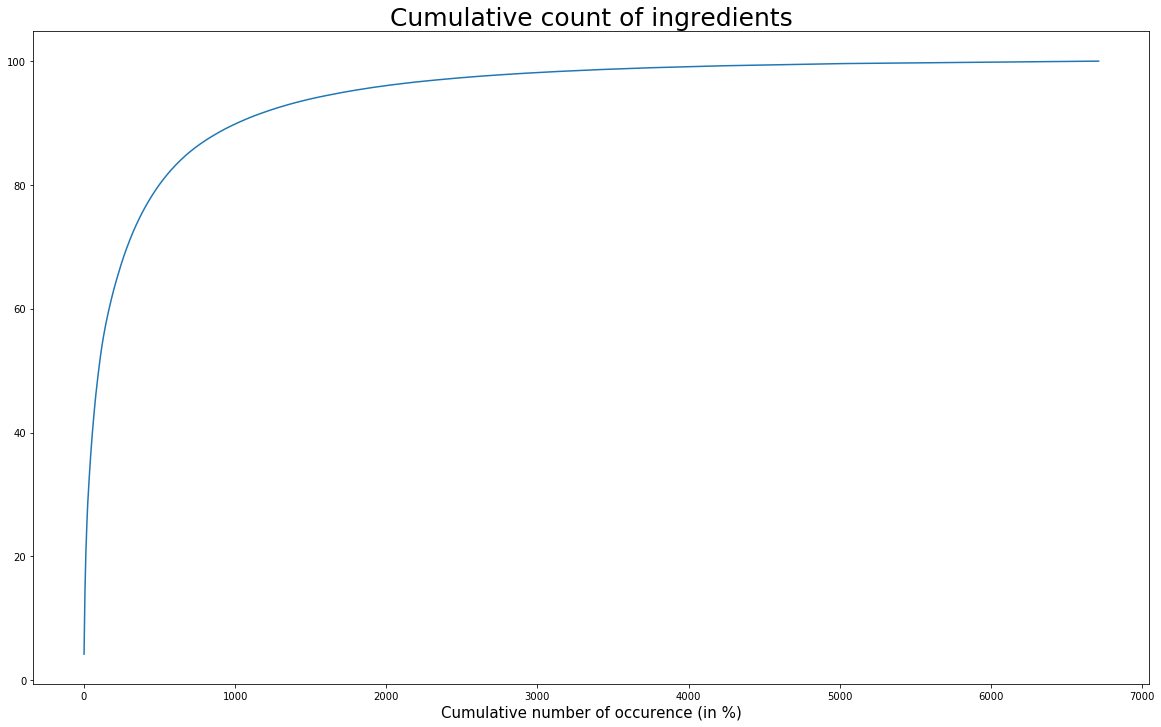

In [5]:
sorted_sum = np.sort(np.asarray(sum_).reshape(-1))[::-1]
cum_sum = np.cumsum(sorted_sum)
cum_sum = cum_sum / cum_sum.max() * 100

plt.plot(cum_sum)
plt.title("Cumulative count of ingredients", fontsize=25)
plt.xlabel("Number of ingredients", fontsize=15)
plt.xlabel("Cumulative number of occurence (in %)", fontsize=15)
plt.show()

We can see that we have a bit less than 7000 unique ingredients and the 2000 most commons represent more than 90% of all ingredients used.

We can have a look at the top and worst ones

In [6]:
from collections import Counter

temp = {ingredient : sum_[0, index] for ingredient, index in TFVectorizer.vocabulary_.items()}
counter = Counter(temp)
del temp

In [7]:
counter.most_common(20)

[('salt', 18049),
 ('onions', 7972),
 ('olive oil', 7972),
 ('water', 7456),
 ('garlic', 7380),
 ('sugar', 6434),
 ('garlic cloves', 6237),
 ('butter', 4846),
 ('ground black pepper', 4785),
 ('all-purpose flour', 4632),
 ('pepper', 4438),
 ('vegetable oil', 4384),
 ('eggs', 3388),
 ('soy sauce', 3296),
 ('kosher salt', 3113),
 ('green onions', 3078),
 ('tomatoes', 3058),
 ('large eggs', 2948),
 ('carrots', 2814),
 ('unsalted butter', 2779)]

In [8]:
counter.most_common()[:-11:-1]

[('crushed cheese crackers', 1),
 ('tomato garlic pasta sauce', 1),
 ('lop chong', 1),
 ('Hidden ValleyÂ® Greek Yogurt Original RanchÂ® Dip Mix', 1),
 ('LiptonÂ® Iced Tea Brew Family Size Tea Bags', 1),
 ('ciabatta loaf', 1),
 ('cholesterol free egg substitute', 1),
 ('orange glaze', 1),
 ('Challenge Butter', 1),
 ('Oscar Mayer Cotto Salami', 1)]

We can see that by using simple ingredients, we may count the same ingredient several times. For example if we have egg and eggs, a different feature will be created for the same feature. Another approach would be to split by words.

## Split by word

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

X_train_joined = [" ".join(x) for x in X_train]
X_val_joined = [" ".join(x) for x in X_val]

TFVectorizer2 = CountVectorizer()
X_train_full = TFVectorizer2.fit_transform(X_train_joined)
X_val_full = TFVectorizer2.transform(X_val_joined)

inv_voc = {v: k for k, v in TFVectorizer2.vocabulary_.items()}

sum2_ = X_train_full.sum(axis=0)

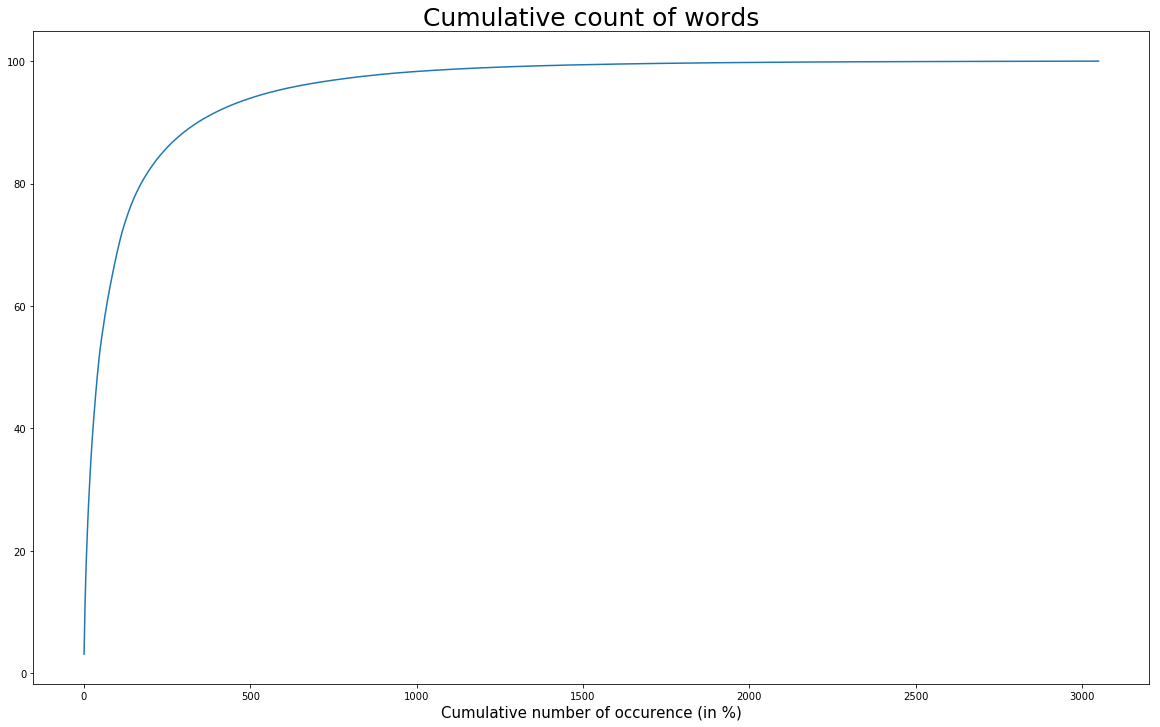

In [10]:
sorted_sum = np.sort(np.asarray(sum2_).reshape(-1))[::-1]
cum_sum = np.cumsum(sorted_sum)
cum_sum = cum_sum / cum_sum.max() * 100

plt.plot(cum_sum)
plt.title("Cumulative count of words", fontsize=25)
plt.xlabel("Number of words", fontsize=15)
plt.xlabel("Cumulative number of occurence (in %)", fontsize=15)
plt.show()

Now we reduce the dimensions by more than 2 (a bit less that 7000 to a bit more than 3000). This will help the model. Nevertheless, we can see that the top 1000 ingredient represents more than 90% of occurences.

Now as we did previously, let's look at word count

In [11]:
temp = {ingredient : sum2_[0, index] for ingredient, index in TFVectorizer2.vocabulary_.items()}
counter = Counter(temp)
del temp

In [12]:
counter.most_common(10)

[('pepper', 25742),
 ('salt', 24462),
 ('oil', 23343),
 ('garlic', 18941),
 ('ground', 18271),
 ('fresh', 17853),
 ('sauce', 13129),
 ('sugar', 12493),
 ('onions', 12341),
 ('cheese', 11776)]

In [13]:
print("Onion = {} vs Onions = {}".format(counter["onion"], counter["onions"]))

Onion = 6901 vs Onions = 12341


In [14]:
counter.most_common()[:-11:-1]

[('chong', 1),
 ('lop', 1),
 ('brew', 1),
 ('challenge', 1),
 ('cotto', 1),
 ('slim', 1),
 ('daiya', 1),
 ('ketjap', 1),
 ('mark', 1),
 ('makers', 1)]

Here it's worse because we have more risk to get the same word only in plural. This is logical because previously there were more mixes possibles. We can see it with onions. To avoid overfitting, we should definitely Stem them.

## Improved Cleaning

Now let's used a Stemmer from nltk (eg the PorterStemmer). In addition, we will remove some useless words like low-fat, minced and so on which is related to preparation instead of ingredients

In [15]:
import re
import nltk
from nltk.stem.porter import PorterStemmer

bracket_remover = re.compile(r"\([^\)]+\)")
digit_remover = re.compile(r"\d+")
stop_words_remover = re.compile(r'low.fat|fresh|crushed|crumbles|ground|minced|powder|chopped|sliced')

stemmer = PorterStemmer()

def clear(ingredient):
    ingredient = bracket_remover.sub("", ingredient)  # remove content between bracket
    ingredient = digit_remover.sub("", ingredient)         # remove digits
    ingredient = stop_words_remover.sub('', ingredient)
    return ingredient.strip().lower()


def stem_sentence(sentence, PS):
    return " ".join([PS.stem(word) for word in sentence.split()]) 

X_train_filtered = []
for recip in X_train:
    recip_filtered = []
    for ingredient in recip:
        ingredient = clear(ingredient)
        ingredient = stem_sentence(ingredient, stemmer)
        recip_filtered.append(ingredient)
    X_train_filtered.append(recip_filtered)
    
X_val_filtered = []
for recip in X_val:
    recip_filtered = []
    for ingredient in recip:
        ingredient = clear(ingredient)
        ingredient = stem_sentence(ingredient, stemmer)
        recip_filtered.append(ingredient)
    X_val_filtered.append(recip_filtered)

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

X_train_joined = [" ".join(x) for x in X_train_filtered]
X_val_joined = [" ".join(x) for x in X_val_filtered]

TFVectorizer2 = CountVectorizer()
X_train_full = TFVectorizer2.fit_transform(X_train_joined)
X_val_full = TFVectorizer2.transform(X_val_joined)

inv_voc = {v: k for k, v in TFVectorizer2.vocabulary_.items()}

sum2_ = X_train_full.sum(axis=0)

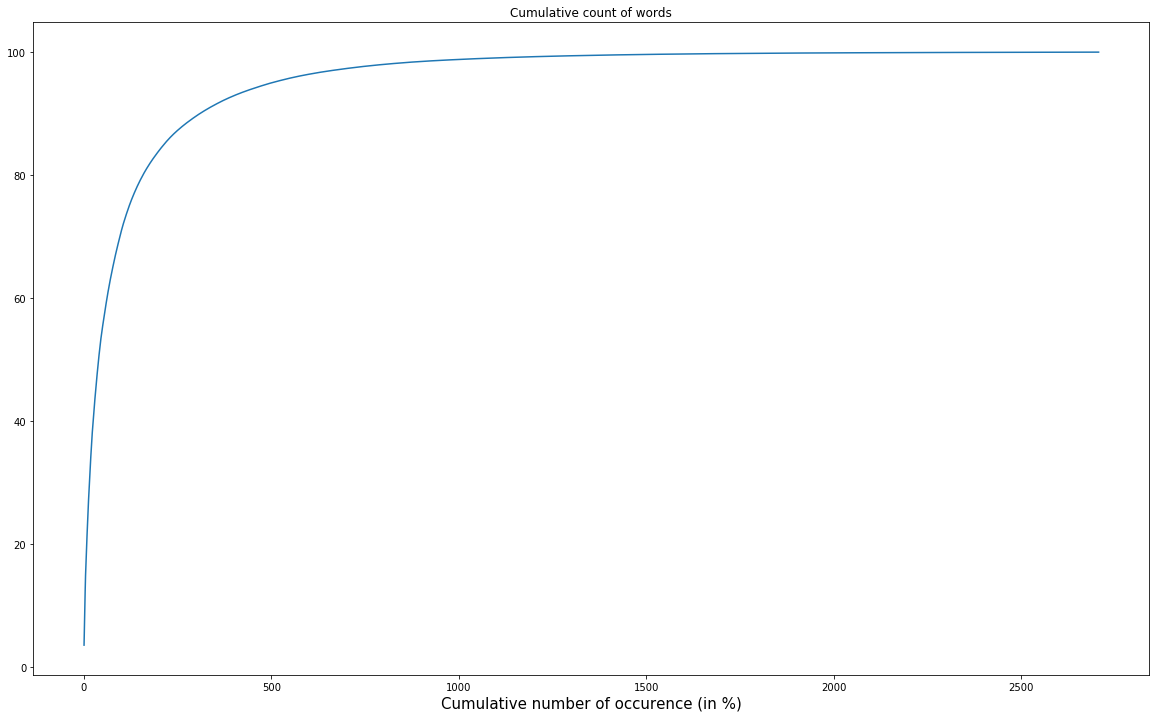

In [17]:
sorted_sum = np.sort(np.asarray(sum2_).reshape(-1))[::-1]
cum_sum = np.cumsum(sorted_sum)
cum_sum = cum_sum / cum_sum.max() * 100

plt.plot(cum_sum)
plt.title("Cumulative count of words")
plt.xlabel("Number of words", fontsize=15)
plt.xlabel("Cumulative number of occurence (in %)", fontsize=15)
plt.show()

In [18]:
temp = {ingredient : sum2_[0, index] for ingredient, index in TFVectorizer2.vocabulary_.items()}
counter = Counter(temp)
del temp

In [19]:
counter.most_common(10)

[('pepper', 27143),
 ('salt', 24661),
 ('oil', 23343),
 ('onion', 19242),
 ('garlic', 18941),
 ('sauc', 13232),
 ('sugar', 12502),
 ('oliv', 12284),
 ('chees', 11633),
 ('chicken', 11557)]

In [20]:
counter.most_common()[:-11:-1]

[('chong', 1),
 ('lop', 1),
 ('challeng', 1),
 ('cotto', 1),
 ('slim', 1),
 ('daiya', 1),
 ('ketjap', 1),
 ('mark', 1),
 ('maker', 1),
 ('conchigli', 1)]

Now nothing is doubled. This help to reduce again dimensions by a bit less than 500 dimensions. We can also remark that the top 10 changed compare to previously due to singular/plural writting.

## Pos-Tag

To reduce again dimensions, we can think of automatically remove some words based on the pos-tag (verbs, adjectives and so on). Nevertheless, if we try it on salt for example, we can see that the detection is poor. It's not always considered as Noun. As a result, i skipped this part

In [21]:
for i in range(100):
    if "salt" in X_val_joined[i]:
        for word, tag in nltk.pos_tag(nltk.word_tokenize(X_val_joined[i])):
            if word == "salt":
                print(word, tag)

salt NN
salt VBD
salt RB
salt VBP
salt NN
salt NN
salt VBP
salt NN
salt VBD
salt NN
salt NN
salt NN
salt NN
salt NN
salt NN
salt NN
salt NN
salt VBD
salt NN
salt NN
salt NN
salt NN
salt NN
salt NN
salt VBD
salt VBP
salt NN
salt NN
salt NN
salt NN
salt NN
salt NN
salt NN
salt NN
salt NN
salt VBD
salt NN
salt NN
salt NN
salt NN
salt NN
salt NN
salt NN
salt NN
salt NN
salt NN
salt NN
salt NN
salt JJ
salt NN
salt NN
salt NN
salt NN
salt NN
salt NN
salt NN
salt NN
salt NN
salt NN


Now if we want to train a model on it (on TF-IDF matrix for example), we will have a matrix of 39000 x 2500 (based on max/min idf). This is quite high. A possibility is too look at Word2Vec model instead of TF-IDF.

# Dimensionnality reduction using Word2Vec

So let's test this model on the filtered data we made previously with stemmer

In [22]:
from gensim.models import word2vec

num_features = 300    # Word vector dimensionality 
min_word_count = 1    # 50% of the corpus                    
num_workers = 4       # Number of CPUs
context = 10          # Context window size; 
                      # let's use avg recipte size                                                                                  
downsampling = 1e-3   # threshold for configuring which 
                    # higher-frequency words are randomly downsampled

# Initialize and train the model 
model = word2vec.Word2Vec(X_train_filtered, workers=num_workers,
                          size=num_features, 
                          min_count = min_word_count,
                          window = context, 
                          sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

len(model.wv.vocab.keys())

C:\python36\envs\machine_learning\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


6364

The model is train will all ingredients. We can remove ingredients above or below a certain threshold but we need all of them to not lose too much information. 

With this model, we can look at similarities. If the result makes sense, we could replace all ingredients with low frequence by the most similar one. But first, let's do some trials.

In [23]:
model.wv.similarity('broccoli', 'bacon')

C:\python36\envs\machine_learning\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.3854515

Ok this is good because they are very differents. Instead of computing similarity, the model can provide directly the most similar one :

In [24]:
model.most_similar("avocado")

C:\python36\envs\machine_learning\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
C:\python36\envs\machine_learning\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('iceberg lettuc', 0.9342395663261414),
 ('queso fresco', 0.9306674599647522),
 ('cotija', 0.9269319176673889),
 ('jalapeno chili', 0.915379524230957),
 ('tomat verd', 0.9130263328552246),
 ('chipotl pepper', 0.9049643278121948),
 ('adobo sauc', 0.9038598537445068),
 ('corn tortilla', 0.9034079313278198),
 ('salsa verd', 0.9031123518943787),
 ('anaheim chile', 0.9030312299728394)]

In [25]:
model.most_similar("salt")

C:\python36\envs\machine_learning\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
C:\python36\envs\machine_learning\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('sea salt', 0.6918206214904785),
 ('kosher salt', 0.6227419376373291),
 ('light whip cream', 0.5449398756027222),
 ('coars salt', 0.5437078475952148),
 ('cube meat', 0.5431402325630188),
 ('vegan yogurt', 0.5346288681030273),
 ('shrimp small uncook', 0.5183416604995728),
 ('lean steak', 0.5156348347663879),
 ('duck drip', 0.5061546564102173),
 ('dri split pea', 0.5009074211120605)]

Unfortunately, we can see thant the result is not perfect. For salt, it provides another salt which is great but with avocado, we have multiple ingredients used with avocados. This is quite logical here as it uses other ingredients for every recipe to train similarities. As a result, if A is always with B, vectors will be very similar even if A is very different to B. 

Just as a trial, I tried Neural Networks on a dataset with either:
- the average vector for all ingredients presents
- the min vector for all ingredients presents
- the max vector for all ingredients presents
- all 3 above 
- all 3 above + a feautre with the number of ingredients

Best results are with a very small NN and reach 68%.

# Labels

Just for information, We can also look at the balance for every origines. The dataset is not very balanced and can create troubles

In [26]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
y_train_enc = lb.fit_transform(y_train_filtered)

ohe =  OneHotEncoder(dtype=np.bool)
y_train_OHE = ohe.fit_transform(y_train_enc.reshape(-1,1))

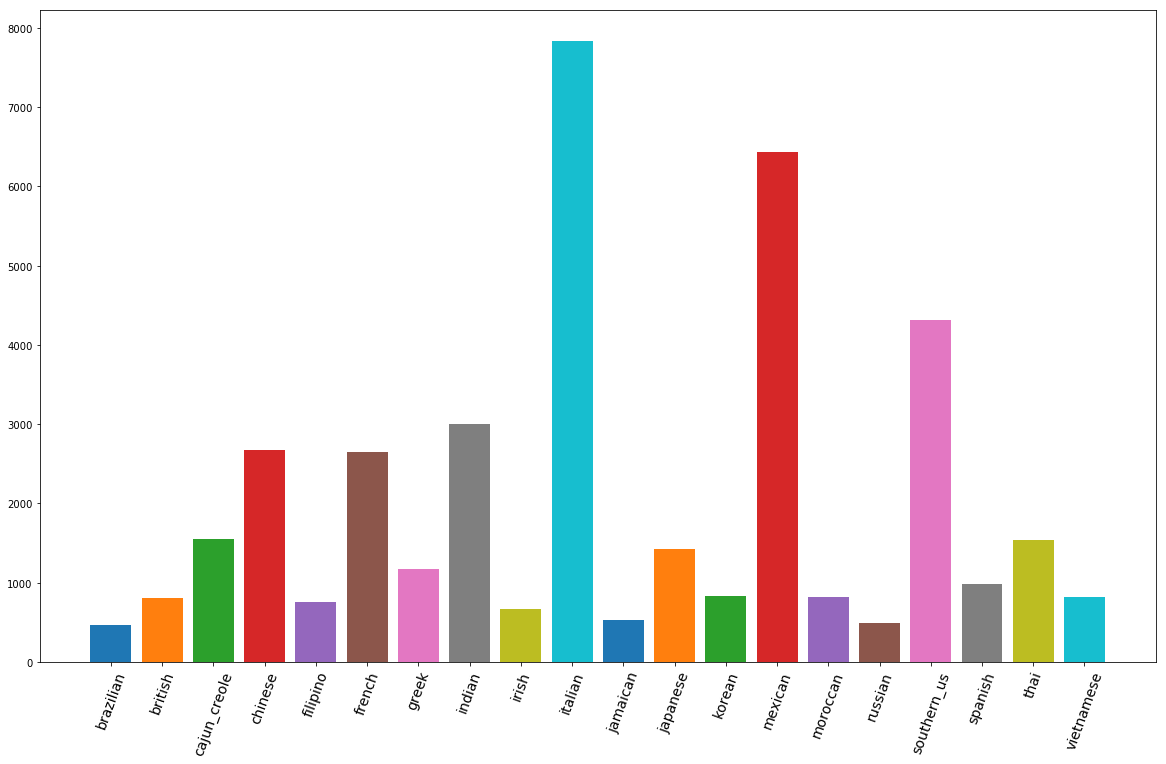

In [27]:
fig, ax = plt.subplots()
for i, value in enumerate(y_train_OHE.sum(axis=0).tolist()[0]):
    ax.bar(i, value)
plt.xticks(range(i+1), lb.classes_)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    tick.label.set_rotation(70)
plt.show()

# Models

Based on the fail with Word2Vec, we have to stay of standard models. Before to do standard approaches, let's try an a very simple model like a Q-learning. The idea is to mimic human thinking. 

# Q evaluation

If we show to a human a recipe with for example :

- water
- salt
- spaghetti
- Tomatoes sauce
- Beaf meat

A human won't be able to find that it's italian with only water and salt because it's common for a lot a recipe but spaghetti will nearly always belong to italian recipes. The 2 other won't helps a lot to find italy but will at least not penalize Italy. 

To do so, we will just count for every ingredient to origin in a Q matrix. After for test, we will just summ all rows and pick the country with the best score.

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_filtered, y_train_filtered, test_size=0.2, random_state=42)

In [29]:
flatten = list(set([ingredient for recipe in X_train for ingredient in recipe]))
len(flatten)

6006

In [30]:
origine, count = np.unique(y_train, return_counts=True)

In [31]:
columns = list(np.unique(y_train))

In [32]:
Q = np.zeros((len(flatten), 20))
row = 0
for recipe, label in zip(X_train, y_train):
    col = columns.index(label)
    for ingredient in recipe:
        row = flatten.index(ingredient)
        Q[row, col] += 1

In [33]:
Q

array([[0., 0., 0., ..., 0., 1., 0.],
       [1., 2., 0., ..., 0., 4., 0.],
       [1., 0., 5., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 2., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.]])

Now we have the matrix, we can try several balances: 
    - normalize by number of recipes for each country (to "balance" the dataset)
    - divide by the number of occurence of every ingredients (similar to TI-IDF)
    - Apply a softmax by row
    - ...
    
After test, the best result is with a simple normlisation by row.

In [34]:
# div by number of total occurence... 
new_Q = Q / Q.sum(axis=1)[:, np.newaxis] 

# new option, divide by column based on number of recipe + devide by row based on count instead of sum
# new_Q = Q / count
# new_Q = (new_Q > 0).sum(axis=1)[:, np.newaxis]

# only normlize by row
# new_Q = (Q > 0).sum(axis=1)[:, np.newaxis]

# softmax with or without division by number of occurence
# def softmax(x):
#     e = np.exp(x)
#     return e / e.sum()


# new_Q = np.apply_along_axis(softmax, axis=1, arr=Q)
# new_Q = new_Q / (Q>0).sum(axis=1)[:, np.newaxis] 

In [35]:
acc = []
for recipe, label in zip(X_test, y_test):
    idx = []
    for ingredient in recipe:
        if ingredient in flatten:
            idx.append(flatten.index(ingredient))
    result = new_Q[idx].sum(axis=0)
    acc.append(columns[np.argmax(result)] == label) 

print(acc.count(True)/len(acc))

0.6329686910599773


63% is not so bad for such a simple model. In fact, it's quite close to Markov Models too as we try to get probablities of every class by ingredients. Now let's try other models.

## Preparation

As we already mentionned previously, we know the cleanup to apply, let's just prepare our train/test set with TF-IDF matrix.

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X_train_joined = [" ".join(x) for x in X_train_filtered]
X_val_joined = [" ".join(x) for x in X_val_filtered]

y_train_joined = y_train[:]

# Split and Build TF-IDF

tfv=TfidfVectorizer(min_df=0, max_features=None, strip_accents='unicode',lowercase=True,
                    analyzer='word', token_pattern=r'\w{3,}', ngram_range=(1,1),
                    use_idf=True,smooth_idf=True, sublinear_tf=True, stop_words = "english")

X_train, X_test, y_train, y_test = train_test_split(X_train_joined, y_train_filtered, test_size=0.2, random_state=42)

X_train_transform = tfv.fit_transform(X_train)
X_test_transform = tfv.transform(X_test)
X_val_transform = tfv.transform(X_val_joined)

# Label Encoding

from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Conversion Label to OHE

from sklearn.preprocessing import OneHotEncoder

ohe =  OneHotEncoder()
y_train_OHE = ohe.fit_transform(y_train.reshape(-1,1))
y_test_OHE = ohe.fit_transform(y_test.reshape(-1,1))

### LogisticRegression

Now matrices are ready, we can test several models and check accuracy

In [37]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, multi_class='ovr', penalty="l1", dual=False, tol=0.0001, C=0.99, fit_intercept=True, intercept_scaling=1)
clf.fit(X_train_transform, y_train)

from sklearn.metrics import accuracy_score
print("Train Accuracy : ", accuracy_score(y_train, clf.predict(X_train_transform)))
print("Test Accuracy : ", accuracy_score(y_test, clf.predict(X_test_transform)))

Train Accuracy :  0.8066645708896574
Test Accuracy :  0.7888846975983905


### MultinomialNB

In [38]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=0.1)

clf.fit(X_train_transform, y_train)

from sklearn.metrics import accuracy_score
print("Train Accuracy : ", accuracy_score(y_train, clf.predict(X_train_transform)))
print("Test Accuracy : ", accuracy_score(y_test, clf.predict(X_test_transform)))

Train Accuracy :  0.7649481295190191
Test Accuracy :  0.7433672827863699


### GradientBoostingClassifier

This model was not finalized as it is very slow

In [39]:
# from sklearn.ensemble import GradientBoostingClassifier

# clf = GradientBoostingClassifier(min_samples_split=4,
#                                  verbose = 1,
#                                  n_estimators=50,
#                                  max_depth = 8,
#                                 )
# clf.fit(X_train_transform, y_train)

# from sklearn.metrics import accuracy_score
# print(accuracy_score(y_train, clf.predict(X_train_transform)))
# print(accuracy_score(y_test, clf.predict(X_test_transform)))

### Neural Networks

I spent lot of time on this part to try topologies, dimensionnaly reduction using Word2Vec or SVD. I'll just do a simple model as a baseline but based on trials, it's difficult to reach more than 78%. In addition, there is a high overfitting if we keep a long training. A regularizer is good solution for that but if I increase if to avoid overfitting, I decrease a lot the test accuracy too.

In [40]:
from keras.models import Sequential
from keras.layers import Dense, Activation
# from keras.callbacks import EarlyStopping
# from keras.models import load_model
from keras import regularizers

from keras import backend as K

C:\python36\envs\machine_learning\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [41]:
K.clear_session()

model = Sequential()
model.add(Dense(256, activation = "relu", input_shape=(X_train_transform.shape[1],), kernel_regularizer=regularizers.l1(0.00001)))  # , kernel_regularizer=regularizers.l2(0.001)  https://keras.io/regularizers/
model.add(Dense(128, activation = "relu"))   #, kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.001)
# model.add(Dense(64, activation = "relu")) 
# model.add(Dense(32, activation = "relu")) 
model.add(Dense(20, activation = "softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               645632    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 20)                2580      
Total params: 681,108
Trainable params: 681,108
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(optimizer="Nadam",
              loss='categorical_crossentropy',
              metrics=["accuracy", "top_k_categorical_accuracy"])  # top 5 par defaut

In [ ]:
model.fit(x=X_train_transform, y=y_train_OHE, 
          batch_size=100, 
          epochs=50, 
          verbose=2, 
          validation_data=(X_test_transform, y_test_OHE),
         )

Train on 31810 samples, validate on 7953 samples
Epoch 1/50
 - 4s - loss: 1.1545 - acc: 0.6943 - top_k_categorical_accuracy: 0.9113 - val_loss: 0.8941 - val_acc: 0.7655 - val_top_k_categorical_accuracy: 0.9574
Epoch 2/50
 - 2s - loss: 0.8047 - acc: 0.7930 - top_k_categorical_accuracy: 0.9685 - val_loss: 0.8448 - val_acc: 0.7805 - val_top_k_categorical_accuracy: 0.9644
Epoch 3/50
 - 2s - loss: 0.7335 - acc: 0.8150 - top_k_categorical_accuracy: 0.9775 - val_loss: 0.9061 - val_acc: 0.7681 - val_top_k_categorical_accuracy: 0.9627
Epoch 4/50
 - 2s - loss: 0.6891 - acc: 0.8322 - top_k_categorical_accuracy: 0.9818 - val_loss: 0.8820 - val_acc: 0.7764 - val_top_k_categorical_accuracy: 0.9650
Epoch 5/50
 - 2s - loss: 0.6370 - acc: 0.8499 - top_k_categorical_accuracy: 0.9873 - val_loss: 1.1463 - val_acc: 0.6980 - val_top_k_categorical_accuracy: 0.9556
Epoch 6/50
 - 2s - loss: 0.5895 - acc: 0.8642 - top_k_categorical_accuracy: 0.9903 - val_loss: 0.8780 - val_acc: 0.7953 - val_top_k_categorical_ac

### SVC

Based on some Kaggle kernels, I took values of trained SVC to avoid Grid Search. The model being slow to train (around 35 min for a training), this will required several hours to find proper parameters using GridSearch.  

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

classifier = SVC(C=100, # penalty parameter
                 kernel='rbf', # kernel type, rbf working fine here
                 degree=3, # default value
                 gamma=1, # kernel coefficient
                 coef0=1, # change to 1 from default value of 0.0
                 shrinking=True, # using shrinking heuristics
                 tol=0.001, # stopping criterion tolerance 
                 probability=False, # no need to enable probability estimates
                 cache_size=200, # 200 MB cache size
                 class_weight=None, # all classes are treated equally 
                 verbose=False, # print the logs 
                 max_iter=-1, # no limit, let it run
                 decision_function_shape=None, # will use one vs rest explicitly 
                 random_state=None)

clf = OneVsRestClassifier(classifier, n_jobs=-1)
clf.fit(X_train_transform.todense(), y_train)

from sklearn.metrics import accuracy_score
print("Train Accuracy : ", accuracy_score(y_train, clf.predict(X_train_transform.todense())))
print("Test Accuracy : ", accuracy_score(y_test, clf.predict(X_test_transform.todense())))

# Conclusion

In this notebook, we explored multiple ways to clean and reduce dimensions on text data. 
I used for the first time Word2Vec and allows me to understand the basics, benefits and drawbacks. 

The current result gives 81.788% in Kaggle competition less than 1% below the best team (82.622%). In Kaggle several people copy pasted a present Kernel which gives slightly better resutl with less pre-processing. As a result, I guess the model is slightly overfitting (as onions is different to onions for example) but have but luck more accuracy on this specific test set.